# Librerias

In [32]:
!pip install ipython-autotime
!pip install powerlaw
!pip install networkx
!pip install gensim
!pip install sklearn
!pip install nltk
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 6.1 MB 8.4 MB/s            
     |████████████████████████████████| 635 kB 10.9 MB/s            
     |████████████████████████████████| 42 kB 1.7 MB/s             
     |████████████████████████████████| 9.9 MB 9.3 MB/s            
     |████████████████████████████████| 128 kB 10.5 MB/s            
     |████████████████████████████████| 11.3 MB 1.2 MB/s            
     |████████████████████████████████| 452

In [1]:
%matplotlib inline 
%load_ext autoreload
%load_ext autotime
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd   
import powerlaw
import spacy
import time
import seaborn as sns

from gensim import corpora, models, similarities, matutils
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from itertools import product
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 

time: 2.83 s (started: 2021-12-12 11:07:44 -03:00)


In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

time: 758 µs (started: 2021-12-12 01:32:51 -03:00)


## Funciones utiles

In [2]:
# del notebook de luz
# Reduccion de la dimensionalidad y visualizacion 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

time: 1.65 ms (started: 2021-12-12 11:07:47 -03:00)


# Dataset:

**Datos**: https://smallworldofwords.org/en/project/research#download
Notebooks del research de la pagina: https://github.com/SimonDeDeyne/SWOWEN-2018

English Data

Word association and participant data for 100 primary, secondary and tertiary responses to 12,292 cues. The data published in Behavior Research Methods were collected between 2011 and 2018. The preprocessed data consist of normalizations of cues and responses by spell-checking them, correcting capitalization and Americanizing. In addition to normalizing cues and responses, the preprocessed file contains data in which each cue is judged by exactly 100 participants (see Github repository for details).

Sometimes it's convenient to know how many participants give a specific response to a cue. In this case, you should download the associative strength files (i.e. the conditional probability of a response given a cue).

Cue statistics provides information about which words were known, and how many responses for each cue were missing. Response statistic includes response counts for tokens and different types.

When using these data, please cite: De Deyne, S., Navarro, D. J., Perfors, A., Brysbaert, M., & Storms, G. (2018). The “Small World of Words” English word association norms for over 12,000 cue words. Behavior Research Methods. DOI 10.3758/s13428-018-1115-7.

 Scripts with a processing pipeline to analyse these data in R can be obtained from the SWOWEN-2018 github repository. Note to R users: use the following command to deal with quotation, otherwise the entire file might not be read in correctly. X= read_delim('strength.SWOW-EN.R123.csv',delim='\t',quote = '',escape_backslash = F,escape_double = F)



In [36]:
# filename = '/content/drive/MyDrive/Maestria/2021.04.CyT/TP-grupo-2/strength.SWOW-EN.R1.csv'
# df = pd.read_csv(filename, sep='\t')

time: 924 µs (started: 2021-12-12 01:32:51 -03:00)


In [3]:
# path = '/content/drive/MyDrive/Maestria/2021.04.CyT/TP-grupo-2/03.TP2/'
path = '/home/lucas/Desktop/2021/Maestria/02.04.Data.Mining.C.y.T/TP/05.Tp2/'
filename = path + 'SWOW-EN.R100.csv'
df = pd.read_csv(filename)

time: 2.16 s (started: 2021-12-12 11:07:52 -03:00)


In [38]:
df

Unnamed: 0       id  participantID  age gender nativeLanguage  \
0                 1       29              3   33     Fe  United States   
1                 2       30              3   33     Fe  United States   
2                 3       31              3   33     Fe  United States   
3                 4       32              3   33     Fe  United States   
4                 5       33              3   33     Fe  United States   
...             ...      ...            ...  ...    ...            ...   
1228195     1228196  1530300         132506   29     Ma         Canada   
1228196     1228197  1530290         132506   29     Ma         Canada   
1228197     1228198  1530291         132506   29     Ma         Canada   
1228198     1228199  1530284         132506   29     Ma         Canada   
1228199     1228200  1530288         132506   29     Ma         Canada   

           country  education           created_at       cue            R1  \
0        Australia        NaN  2011-08-12 02:19:38  although  nevertheless   
1        Australia        NaN  2011-08-12 02:19:38      deal            no   
2        Australia        NaN  2011-08-12 02:19:38     music         notes   
3        Australia        NaN  2011-08-12 02:19:38    inform          tell   
4        Australia        NaN  2011-08-12 02:19:38       way          path   
...            ...        ...                  ...       ...           ...   
1228195  Australia        5.0  2018-08-10 01:56:27   strange          mask   
1228196  Australia        5.0  2018-08-10 01:56:27    sunset           sea   
1228197  Australia        5.0  2018-08-10 01:56:27   useless         pitty   
1228198  Australia        5.0  2018-08-10 01:56:27    volume          loud   
1228199  Australia        5.0  2018-08-10 01:56:27  whenever           who   

                R2        R3  
0              yet       but  
1            cards     shake  
2             band    rhythm  
3           rat on       NaN  
4              via    method  
...            ...       ...  
1228195      weird  stranger  
1228196        sky    clause  
1228197  worthless     worth  
1228198      music       key  
1228199      where    always  

[1228200 rows x 13 columns]

time: 19.7 ms (started: 2021-12-12 01:32:54 -03:00)


# Transformaciones

Los datos que se cargan de la página tienen unas primeras columnas con metadata que en principio no se va a usar, la columna con el CUE y las tres respuestas R1, R2, y R3. R1 suele estar completa, no así R2 y R3, la sugerencia es tirar estas últimas dos columnas porque ya se tienen muchos datos para trabajar. Sin embargo puede ser interesante incluirlas, y en el trabajo de referencia lo hacen. 

TODO:

* Columnas
  * A priori vamos a usar solo cue y R1 (R2 y R3 opcionales)
* Filas
  * Recomendamos tirar:
    * palabras cortas (de una letra por ej.), 
    * palabras que no estén como CUE Y R1, 
    * pares CUE-R1 que aparezcan menos que una cantidad de veces, 
    * pares CUE-R1 cuya frecuencia sea muy pequeña respecto a la del CUE (CUE − R1/R1 pequeño). 
  * También pueden tirar si le aparecen N aN y, 
  * **sugerimos fuertemente** filtrar las palabras que no aparecen en el corpus de word2vec. 

Así como pueden tomar las respuestas R2 y R3, también pueden realizar otros filtros que consideren más adecuados. 

## Drop de columnas

In [39]:
drop_cols = ['Unnamed: 0', 'id', 'participantID', 'age', 'gender', 'nativeLanguage','country','education','created_at','R2','R3']
df = df.drop(columns=drop_cols).copy()

time: 48.4 ms (started: 2021-12-12 01:32:54 -03:00)


In [40]:
df.columns

Index(['cue', 'R1'], dtype='object')

time: 2.14 ms (started: 2021-12-12 01:32:54 -03:00)


## Stop words


https://stackabuse.com/removing-stop-words-from-strings-in-python/#usingpythonsgensimlibrary
https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

##### Nltk


In [41]:
# from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
# from nltk.tokenize import word_tokenize
# Ref. https://stackabuse.com/removing-stop-words-from-strings-in-python/

[nltk_data] Downloading package punkt to /home/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


False

time: 32.6 ms (started: 2021-12-12 01:32:54 -03:00)


In [42]:
print(f"pre sacado de stopwords: {df.shape}")
print(f"pos sacado de stopwords: {df[~df.cue.isin(nltk.corpus.stopwords.words()) & ~df.R1.isin(nltk.corpus.stopwords.words())].shape}")
# df[~df.cue.isin(nltk.corpus.stopwords.words()) & ~df.R1.isin(nltk.corpus.stopwords.words())].shape

pre sacado de stopwords: (1228200, 2)
pos sacado de stopwords: (1167518, 2)
time: 157 ms (started: 2021-12-12 01:32:54 -03:00)


In [43]:
# df

time: 563 µs (started: 2021-12-12 01:32:55 -03:00)


##### SpaCy

In [53]:
! python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 12.1 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
time: 7.21 s (started: 2021-12-12 01:35:40 -03:00)


In [45]:
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
print(f"pre sacado de stopwords: {df.shape}")
print(f"pos sacado de stopwords: {df[~df.cue.isin(all_stopwords) & ~df.R1.isin(all_stopwords)].shape}")

pre sacado de stopwords: (1228200, 2)
pos sacado de stopwords: (1165107, 2)
time: 686 ms (started: 2021-12-12 01:33:00 -03:00)


#### Gensim

In [46]:
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

time: 636 µs (started: 2021-12-12 01:33:01 -03:00)


In [47]:
print(f"pre sacado de stopwords: {df.shape}")
print(f"pos sacado de stopwords: {df[~df.cue.isin(STOPWORDS) & ~df.R1.isin(STOPWORDS)]}")
# df = df[~df.cue.isin(STOPWORDS) & ~df.R1.isin(STOPWORDS)]


pre sacado de stopwords: (1228200, 2)
pos sacado de stopwords:              cue        R1
2          music     notes
3         inform      tell
4            way      path
6          extra      plus
8          paper      book
...          ...       ...
1228194    rugby  baseball
1228195  strange      mask
1228196   sunset       sea
1228197  useless     pitty
1228198   volume      loud

[1156840 rows x 2 columns]
time: 200 ms (started: 2021-12-12 01:33:01 -03:00)


## Conclusiones

- Tiene sentido? 
- Probablemente no, son relaciones que se presentaron.

## Sacar word 2 vec

In [4]:
w2v_model2 = KeyedVectors.load_word2vec_format(path + 'GoogleNews-vectors-negative300.bin.gz', binary=True)

KeyboardInterrupt: 

time: 10.6 s (started: 2021-12-12 11:08:00 -03:00)


In [ ]:
df.shape

(1228200, 2)

time: 3.69 ms (started: 2021-12-12 01:35:09 -03:00)


In [56]:
# dir(w2v_model2)

time: 832 µs (started: 2021-12-12 01:36:17 -03:00)


In [58]:
df = df[df.cue.isin(w2v_model2.key_to_index) & df.R1.isin(w2v_model2.key_to_index)]

time: 1.93 s (started: 2021-12-12 01:38:04 -03:00)


In [59]:
df.shape

(1103309, 2)

time: 2.01 ms (started: 2021-12-12 01:38:07 -03:00)


## Pares unicos

In [60]:
cue_unicos = df.groupby(by=["cue"]).count()
cue_unicos.sort_values(by='R1', ascending=True)
cue_unicos = cue_unicos.reset_index().rename(columns={"R1": "cant_cue"})
cue_unicos

cue  cant_cue
0            Abel        90
1      Aboriginal        92
2            Adam        95
3           Advil        75
4          Africa        93
...           ...       ...
11834     zombies        90
11835        zone        94
11836         zoo        98
11837        zoom        93
11838    zucchini        95

[11839 rows x 2 columns]

time: 195 ms (started: 2021-12-12 01:38:07 -03:00)


In [61]:
# cue_unicos.sort_values(by='cant_cue', ascending=True).cant_cue.value_counts()

time: 908 µs (started: 2021-12-12 01:38:08 -03:00)


In [62]:
df['dummy'] = 1
cue_r1_unicos = df.groupby(by=['cue', 'R1']).sum()
cue_r1_unicos = cue_r1_unicos.reset_index()
cue_r1_unicos

cue         R1  dummy
0           Abel      Bible      4
1           Abel       Cain     55
2           Abel      Caine      3
3           Abel       Cole      1
4           Abel       Kain      3
...          ...        ...    ...
428113  zucchini      plant      1
428114  zucchini       soup      1
428115  zucchini     squash     12
428116  zucchini  vegetable     18
428117  zucchini       yuck      1

[428118 rows x 3 columns]

time: 452 ms (started: 2021-12-12 01:38:08 -03:00)


In [63]:
cue_r1_unicos.sort_values(by="dummy", ascending=True)

cue              R1  dummy
214058        just          rights      1
258581      nuance         details      1
258579      nuance      complexity      1
258576      nuance           color      1
258575      nuance  characteristic      1
...            ...             ...    ...
249522  mozzarella          cheese     86
179194        halt            stop     87
247061         moo             cow     91
7451      Parmesan          cheese     92
2000       Cheddar          cheese     93

[428118 rows x 3 columns]

time: 49.1 ms (started: 2021-12-12 01:38:08 -03:00)


In [64]:
df_final = pd.merge(cue_r1_unicos, cue_unicos, on="cue", how="left")
df_final = df_final.rename(columns={"dummy": "cant_cue_r1"})
# frecuencia respecto CUE (CUE − R1/R1 pequeño). 
df_final['frecuencia'] = df_final['cant_cue_r1'] / df_final['cant_cue']
df_final

cue         R1  cant_cue_r1  cant_cue  frecuencia
0           Abel      Bible            4        90    0.044444
1           Abel       Cain           55        90    0.611111
2           Abel      Caine            3        90    0.033333
3           Abel       Cole            1        90    0.011111
4           Abel       Kain            3        90    0.033333
...          ...        ...          ...       ...         ...
428113  zucchini      plant            1        95    0.010526
428114  zucchini       soup            1        95    0.010526
428115  zucchini     squash           12        95    0.126316
428116  zucchini  vegetable           18        95    0.189474
428117  zucchini       yuck            1        95    0.010526

[428118 rows x 5 columns]

time: 96.3 ms (started: 2021-12-12 01:38:08 -03:00)


In [65]:
print(f"Shape df_final: {df_final.shape}")
print(f"Shape df_final frecuencia > 0.01: {df_final[df_final.frecuencia > 0.01].shape}") 
print(f"Shape df_final frecuencia > 0.05: {df_final[df_final.frecuencia > 0.025].shape}") # 16K nodos
print(f"Shape df_final frecuencia > 0.05: {df_final[df_final.frecuencia > 0.05].shape}") # 13K nodos
print(f"Shape df_final frecuencia > 0.10: {df_final[df_final.frecuencia > 0.10].shape}") # 12K nodos
print(f"Shape df_final frecuencia > 0.25: {df_final[df_final.frecuencia > 0.25].shape}") #6K nodos
print(f"Shape df_final frecuencia > 0.5: {df_final[df_final.frecuencia > 0.5].shape}") #1.6K nodos

df_final = df_final[df_final.frecuencia > 0.25]

Shape df_final: (428118, 5)
Shape df_final frecuencia > 0.01: (422149, 5)
Shape df_final frecuencia > 0.05: (83235, 5)
Shape df_final frecuencia > 0.05: (45528, 5)
Shape df_final frecuencia > 0.10: (20326, 5)
Shape df_final frecuencia > 0.25: (5560, 5)
Shape df_final frecuencia > 0.5: (1145, 5)
time: 45.7 ms (started: 2021-12-12 01:38:08 -03:00)


In [66]:
print(f"Cant nodos: {len(set(list(df_final.cue) + list(df_final.R1)))} \n")

Cant nodos: 6467 

time: 4.04 ms (started: 2021-12-12 01:38:08 -03:00)


In [67]:
df_final[df_final.cue == df_final.R1].shape
# df_final.shape

(0, 5)

time: 5.71 ms (started: 2021-12-12 01:38:09 -03:00)


# Tarea 1


## Tarea 3.1: Construcción de los grafos 


Construir un dataframe con los pares únicos CUE-R1, 

Se puede agregar columnas:  
* El número de apariciones del CUE, del par CUE-R1 y del cociente CUE − R1/R1. 

A partir de esta estructura pueden facilmente construir el grafo. 

* Describir este grafo 
  * ¿Número de nodos? 
  * ¿Número de aristas? 
  * ¿Es dirigido? 
  * ¿Es pesado? 
  * ¿Tiene loops? 
  * Etc
* Visualizarlo
* También, pueden visusalizar algún subgrafo dentro de la red. 


-----------------------
-----------------------
-----------------------

In [5]:
G = nx.read_gpickle(path+'pickle/g_sww.gpickle.gz')

time: 113 ms (started: 2021-12-12 11:08:19 -03:00)


In [6]:
g_df = pd.DataFrame(G.degree,columns=['Node','Degree']).set_index('Node')
g_df.T

Node    Abel  Cain  Aboriginal  Australia  Adam  eve  Africa  continent  \
Degree     2     2           1          4     1    1       1          1   

Node    Alaska  cold  ...  youth  youthful  yucky  stripes  zest  zesty  zip  \
Degree       1    24  ...      1         1      1        1     1      1    1   

Node    zodiac  zone  zoo  
Degree       1     1    1  

[1 rows x 6467 columns]

time: 40.9 ms (started: 2021-12-12 11:08:20 -03:00)


In [7]:
g_df.sort_values('Degree',ascending=False).T

Node    money  bird  car  music  food  water  old  dog  sex  happy  ...  \
Degree     72    46   44     42    39     39   34   32   30     27  ...   

Node    assassin  bald  habitat  hairless  assessment  haiku  haha  hacker  \
Degree         1     1        1         1           1      1     1       1   

Node    hack  zoo  
Degree     1    1  

[1 rows x 6467 columns]

time: 14.4 ms (started: 2021-12-12 11:08:22 -03:00)


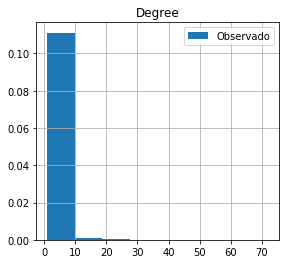

time: 191 ms (started: 2021-12-12 11:08:24 -03:00)


In [8]:
df_g_degree = pd.DataFrame(G.degree,columns=['Node','Degree']).set_index('Node')

plt.figure(figsize=(10,4))
df_g_degree.hist(bins=8,density=True,ax=plt.subplot(121),label='Observado');
plt.legend();

<Figure size 576x288 with 0 Axes>

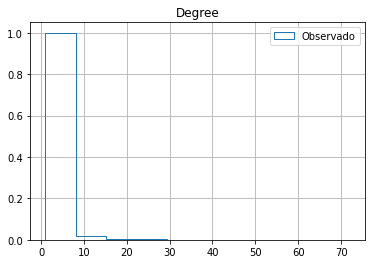

time: 133 ms (started: 2021-12-12 01:38:09 -03:00)


In [72]:
plt.figure(figsize=(8,4));
df_g_degree.hist(density=True,histtype='step',label='Observado', cumulative=-1);
plt.legend();

In [9]:
print(nx.info(G))
print('Is weigthed:',nx.is_weighted(G))
print(f"Nodes: {G.number_of_nodes()}, Aristas: {G.number_of_edges()} \n")

DiGraph with 6467 nodes and 5560 edges
Is weigthed: True
Nodes: 6467, Aristas: 5560 

time: 10.3 ms (started: 2021-12-12 11:08:28 -03:00)


In [10]:
# Tienen multiples aristas
print(G.is_multigraph(), "\n")

False 

time: 770 µs (started: 2021-12-12 11:08:30 -03:00)


In [11]:
nx.is_connected(G)

NetworkXNotImplemented: not implemented for directed type

time: 19.6 ms (started: 2021-12-12 11:08:32 -03:00)


In [12]:
pos_g = nx.spring_layout(G)  #setting the positions with respect to G, not k.

time: 1min 57s (started: 2021-12-12 11:08:36 -03:00)


In [13]:
# # More conected nodes - Ref: https://stackoverflow.com/questions/44532952/find-number-of-connected-edges-to-a-node-and-node-with-max-connected-edges
aux = pd.DataFrame(dict(G.degree()).items())
# list(aux.sort_values(by=1, ascending = False).loc[:, 0].head(250))
# # more_conected = 

time: 21.2 ms (started: 2021-12-12 11:10:34 -03:00)


In [14]:
plt.figure(figsize=(20,10))

othersubgraph = G.subgraph(list(aux.sort_values(by=1, ascending = False).loc[:, 0].head(250)))
# othersubgraph = G.subgraph(list(G.nodes().keys())[0:500])
nx.draw_networkx(othersubgraph, 
                 # pos=pos, 
                 node_color = '#ffe56a', 
                 alpha=0.8,
                 font_size=13,
                 font_color='#8778bf')
plt.show()

# plt.subplot(131)
# nx.draw(G_obs, with_labels=True, font_weight='bold')
# plt.title('spring')

time: 1.48 s (started: 2021-12-12 11:10:34 -03:00)


In [79]:
# Check de palabras
# df_final[df_final.cue.isin(['aardvark'])]
# 'aardvark' in list(G.nodes().keys())

time: 967 µs (started: 2021-12-12 01:42:32 -03:00)


## Tarea 3.2 Word2vec

* Carga el word2vec prentrenado que les proveemos (pero pueden buscar otro),
* A partir de él es posible definir la matríz de adyacencia, 
* y a partir de esta el grafo. 

* Filtrar sólo las palabras que aparecen en Gsww. 
  * Si es necesario pueden realizar los filtros que consideren más adecuados. 

### Describir este grafo 

* ¿Número de nodos?
* ¿Número de aristas?
* ¿Es dirigido?
* ¿Es pesado?
* ¿Tiene loops?
* Etc

Visualizarlo


In [80]:
lista_unica_palabras = list(df_final.cue.unique()) #+ list(df_final.R1.unique())
lista_unica_palabras = lista_unica_palabras #[0:1000] 
len(lista_unica_palabras)

5234

time: 4.98 ms (started: 2021-12-12 01:42:33 -03:00)


In [15]:
G_w2v = nx.read_gpickle(path+'pickle/G_w2v.gpickle.gz')

time: 2.06 s (started: 2021-12-12 11:10:36 -03:00)


Ver características de los grafos

In [16]:
G_w2v_df = pd.DataFrame(G_w2v.degree,columns=['Node','Degree']).set_index('Node')
G_w2v_df.T

Node    alone  puddle  almighty  jail  slinky  slap  suds  awake  cemetery  \
Degree    485     597       632   662     802   739   636    608       983   

Node    plaque  ...  dear  post  single  just  plump  heavy  foretell  rays  \
Degree    1185  ...   673  1177     777    56    579    866       854   888   

Node    ammunition  sometimes  
Degree         959        192  

[1 rows x 6467 columns]

time: 28.9 ms (started: 2021-12-12 11:10:38 -03:00)


In [17]:
G_w2v_df.sort_values('Degree',ascending=False).T

Node    conjunction  joined  inception  chairman  pleased  senior  April  \
Degree         3077    3051       3027      2891     2882    2775   2764   

Node    addition  currently  October  ...  actually   if  really  thought   I  \
Degree      2760       2696     2693  ...       108  103     103      101  98   

Node    guess  even  kind  so  just  
Degree     94    89    82  77    56  

[1 rows x 6467 columns]

time: 21.6 ms (started: 2021-12-12 11:10:38 -03:00)


In [18]:
df_G_w2v_degree = pd.DataFrame(G_w2v.degree,columns=['Node','Degree']).set_index('Node')

plt.figure(figsize=(10,4))
df_G_w2v_degree.hist(bins=8,density=True,ax=plt.subplot(121),label='Observado');
plt.legend();

time: 240 ms (started: 2021-12-12 11:10:38 -03:00)


<Figure size 576x288 with 0 Axes>

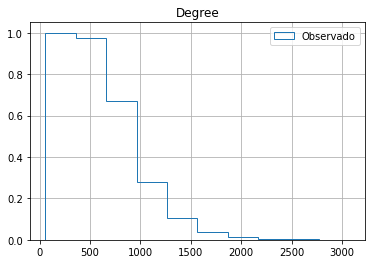

time: 193 ms (started: 2021-12-12 11:10:38 -03:00)


In [19]:
plt.figure(figsize=(8,4));
df_G_w2v_degree.hist(density=True,histtype='step',label='Observado', cumulative=-1);
plt.legend();

In [20]:
print(nx.info(G_w2v))
print('Is weigthed:',nx.is_weighted(G_w2v))
print(f"Nodes: {G_w2v.number_of_nodes()}, Aristas: {G_w2v.number_of_edges()} \n")


Graph with 6467 nodes and 2712501 edges
Is weigthed: True
Nodes: 6467, Aristas: 2712501 

time: 1.29 s (started: 2021-12-12 11:10:38 -03:00)


In [21]:
# Tienen multiples aristas
print(G_w2v.is_multigraph(), "\n")

False 

time: 1.31 ms (started: 2021-12-12 11:10:40 -03:00)


In [22]:
print(nx.is_connected(G_w2v), "\n")

True 

time: 126 ms (started: 2021-12-12 11:10:40 -03:00)


In [23]:
pos_g_w2v = nx.spring_layout(G_w2v)  #setting the positions with respect to G, not k.

time: 3min 17s (started: 2021-12-12 11:10:40 -03:00)


In [24]:
# # More conected nodes - Ref: https://stackoverflow.com/questions/44532952/find-number-of-connected-edges-to-a-node-and-node-with-max-connected-edges
aux = pd.DataFrame(dict(G_w2v.degree()).items())
# list(aux.sort_values(by=1, ascending = False).loc[:, 0].head(250))
# # more_conected = 

time: 16.1 ms (started: 2021-12-12 11:13:57 -03:00)


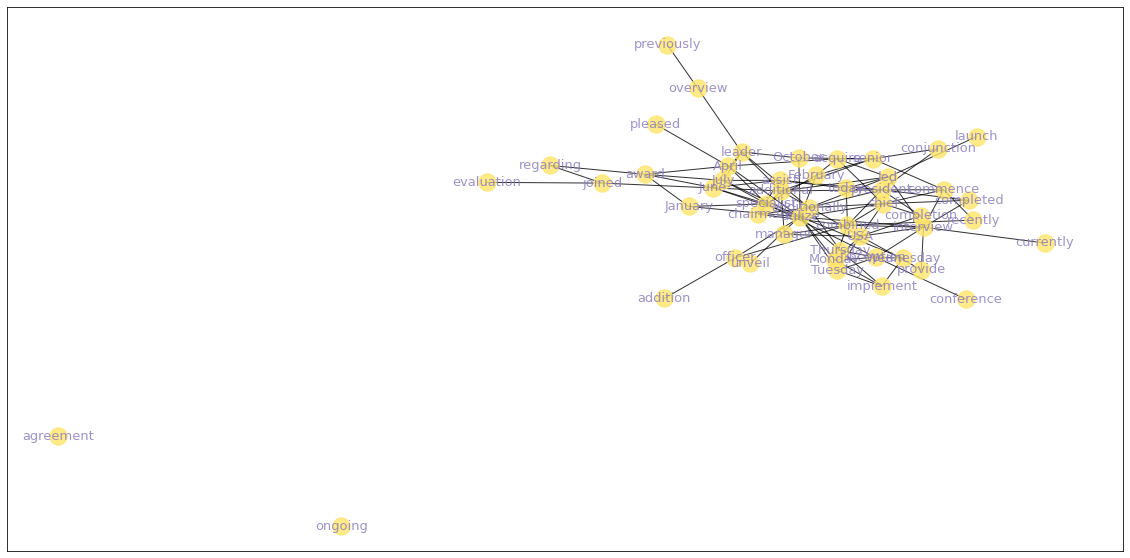

time: 527 ms (started: 2021-12-12 11:13:57 -03:00)


In [25]:
plt.figure(figsize=(20,10))

othersubgraph = G_w2v.subgraph(list(aux.sort_values(by=1, ascending = False).loc[:, 0].head(50)))
# othersubgraph = G.subgraph(list(G.nodes().keys())[0:500])
nx.draw_networkx(othersubgraph, 
                 # pos=pos, 
                 node_color = '#ffe56a', 
                 alpha=0.8,
                 font_size=13,
                 font_color='#8778bf')
plt.show()

# plt.subplot(131)
# nx.draw(G_obs, with_labels=True, font_weight='bold')
# plt.title('spring')

# 4. Tarea 2: Carácterización de los grafos 

Comparar los dos grafos (word2vec vs grafo respuestas) en terminos de:

* medidas de cliques/clustering,
* medidas de centralidad3,
* distribución de pesos,
* distribución de grado,
* asortatividad,
* camino mínimo, 
* diámetro, etc. 

¿Qué pueden decir de cada uno de los grafos? ¿Y qué pueden decir de la comparación entre ellos? 

**Opcional 1**: ¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado? 


## Medias de centralidad
Es posible calcular las medias de centralidad:

- Grado

- Intermediación (betweenness)

- Cercanía (Closeness)

- Centralidad de autovectores (Eigenvector centrality)

En las salidas siguientes se muestran llamadas a las distintas funciones de centralidad, y se muestran los 10 
individuos con valores mayores para cada medida y red.


### De grado

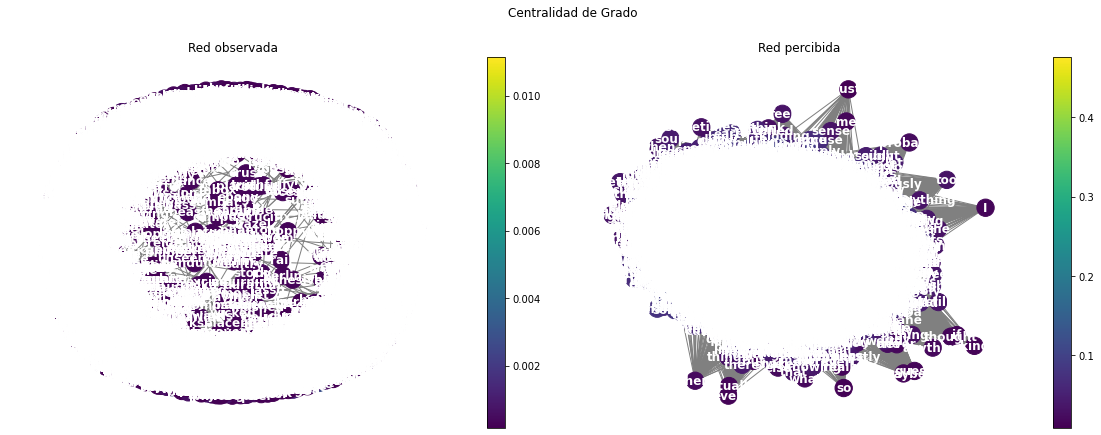

time: 2min 5s (started: 2021-12-12 11:13:58 -03:00)


In [26]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.degree_centrality(G)
values = [v for n,v in centrality.items()]
nx.draw(G,pos=pos_g, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.degree_centrality(G_w2v)
values = [v for n,v in centrality.items()]
nx.draw(G_w2v,pos=pos_g_w2v, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])

plt.suptitle('Centralidad de Grado',y=1.0)
plt.tight_layout();

### De betwenness

In [27]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.betweenness_centrality(G)
values = [v for n,v in centrality.items()]
nx.draw(G,pos=pos_g, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.betweenness_centrality(G_w2v)
values = [v for n,v in centrality.items()]
nx.draw(G_w2v,pos=pos_g_w2v, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])

plt.suptitle('Centralidad de betweenness',y=1.0)
plt.tight_layout();

### De closeness

NameError: ignored

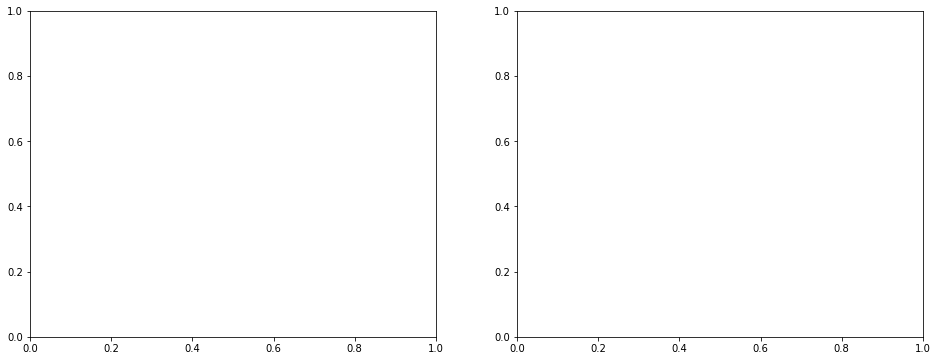

time: 361 ms (started: 2021-12-11 18:48:12 +00:00)


In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.closeness_centrality(G)
values = [v for n,v in centrality.items()]
nx.draw(G,pos=pos_g, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.closeness_centrality(G_w2v)
values = [v for n,v in centrality.items()]
nx.draw(G_w2v,pos=pos_g_w2v, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de closeness',y=1.0);
plt.tight_layout();

### De autovalor

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

centrality = nx.eigenvector_centrality(G)
values = [v for n,v in centrality.items()]
nx.draw(G,pos=pos_g, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[0])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[0])
axs[0].set_title('Red observada');

centrality = nx.eigenvector_centrality(G_w2v)
values = [v for n,v in centrality.items()]
nx.draw(G_w2v,pos=pos_g_w2v, with_labels=True, font_weight='bold',node_color = values, font_color='white', edge_color='gray',ax=axs[1])
axs[1].set_title('Red percibida');
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(values), vmax=max(values))); sm.set_array([]); cbar = plt.colorbar(sm,ax=axs[1])
plt.suptitle('Centralidad de autovector',y=1.0);
plt.tight_layout();

### Comparacion

In [ ]:
X = [nx.degree_centrality(G).values(),nx.betweenness_centrality(G).values(),nx.closeness_centrality(G).values(),nx.eigenvector_centrality(G).values() ]
df_centralidad_obs = pd.DataFrame(X,index=['Obs_Degree','Obs_Betweeness','Obs_Closeness','Obs_Eigenvector']).T
X = [nx.degree_centrality(G_w2v).values(),nx.betweenness_centrality(G_w2v).values(),nx.closeness_centrality(G_w2v).values(),nx.eigenvector_centrality(G_w2v).values() ]
df_centralidad_per = pd.DataFrame(X,index=['Per_Degree','Per_Betweeness','Per_Closeness','Per_Eigenvector']).T
sns.heatmap(df_centralidad_obs.join(df_centralidad_per).corr())
plt.title('Correlación medidas de centralidad');

# 5. Tarea 3: Detectar comunidades

1. Elegir algoritmo
  * Justificar el porque
  * TODO: Cuales son?
2. Indice de modularidad
  * Que se puede decir de las comunidades?
3. Comparar las comunidades de ambas redes con el índice rand (u otra métrica que consi dere adecuada) ¿Son similares? 

4. Visualizar uno de los grafos, y pintarlo según las comunidades del otro ¿Qué se puede decir? 

También se puede analizar la resolución del algoritmo de por el cuál se detectan las comunidades. Para ello, pueden explorar estructuras dentro de alguna de las comunidades. 

**Opcional 2:** 
Utilizar distintos algoritmos y comparar los resultados. 

**Opcional 3:** 
¿Cómo cambian los resultados si se considere Gsww como no-dirigido o no-pesado? ¿Y para Gw2v? 

**Opcional 4:**

* Utilizar algoritmos de reducción de dimensionalidad (MDS, tSNE, o UMAP) para ubicar las palabras en dos dimensiones y pintar según las comunidades identificadas. 
* Se puede elegir un subconjunto de palabras para que sea más claro.
* También pueden proyectar en el espacio construido con word2vec y pintar según las comunidades identificadas en Gsww, o viceversa. 



# 6. Tarea 4: Small-world y redes prototípicas 

Existen trabajos previos que muestran que tanto la red de asociaciones (Gsww) como la red semántica (Gw2v) tienen estructura de small-world [5, 6]. 

_Comparar las características de redes_, 

* camino mínimo, con distintos modelos de redes, en particular con redes small-world. 
  * generar N redes small-world con el mismo número de nodos y aristas, 
* evaluar si las características medidas en Gsww y Gw2v podrían pertenecer a dichas distribuciones. 

**Opcional 4:** Además de realizar esta tarea con el small-world, repetirlo con las random o scale-free. 


In [99]:
repetitions = 1000
data = []
for i in range(repetitions):
    d = {}
    ## Free scale networks
    G_aux = nx.barabasi_albert_graph(G.number_of_nodes(),10,seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G_aux)
    d['ba_avg_path'] = nx.average_shortest_path_length(G_aux)
    d['ba_avg_degree'] = G_aux.number_of_edges()/G_aux.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([d for n, d in G_aux.degree],discrete=True,xmin=8).alpha
    ## Generate random graph
    G_aux = nx.gnm_random_graph(G.number_of_nodes(),G.number_of_edges(),seed=i)    
    d['er_avg_clus'] = nx.average_clustering(G_aux)
    # Por no conecto
    # d['er_avg_path'] = nx.average_shortest_path_length(G_aux)
    
    ## Modelo Watts y Strogatz, en teoría de redes, se emplea para la construcción de algunas redes de mundo pequeño
    G_aux = nx.newman_watts_strogatz_graph(G.number_of_nodes(),round(G_aux.number_of_edges()/G_aux.number_of_nodes()),0.03,seed=i)
    d['ws_avg_clus'] = nx.average_clustering(G_aux)
    # Por no conecto
    # d['ws_avg_path'] = nx.average_shortest_path_length(G_aux)
    data.append(d)

df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G),0,20,lw=3,color='r')

# axs = df.filter(regex='avg_path').hist(figsize=(12,8),density=True)
# for ax in axs.flatten():
#     ax.vlines(nx.average_shortest_path_length(G),0,20,lw=3,color='r')

KeyboardInterrupt: 

time: 8h 22min 5s (started: 2021-12-12 02:04:24 -03:00)


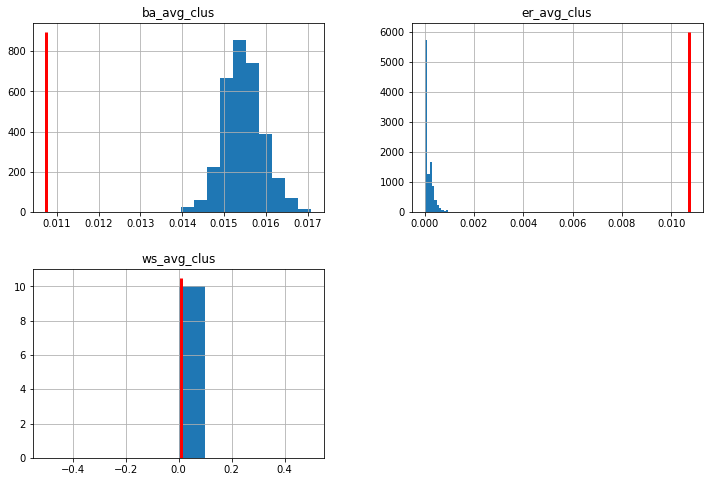

time: 604 ms (started: 2021-12-12 10:39:04 -03:00)


In [116]:
df = pd.DataFrame(data)
axs = df.filter(regex='avg_clus').hist(figsize=(12,8),density=True)
for ax in axs.flatten():
    ax.vlines(nx.average_clustering(G),0,ax.get_ylim()[1],lw=3,color='r')

In [115]:
# dir(axs[0][0])
axs[0][0].get_ylim()[1]

895.3815053945399

time: 2.74 ms (started: 2021-12-12 10:38:57 -03:00)


In [104]:
df.to_pickle(path + "pickle/df_ejercicio_4.pickle.gz", compression="gzip")

time: 13.7 ms (started: 2021-12-12 10:28:39 -03:00)


In [101]:
df.shape

(674, 6)

time: 4.29 ms (started: 2021-12-12 10:26:51 -03:00)


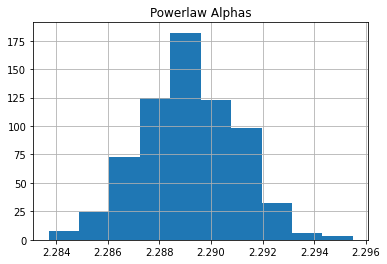

time: 139 ms (started: 2021-12-12 10:47:27 -03:00)


In [117]:
plt.figure()
df['ba_alpha'].hist();
plt.title('Powerlaw Alphas');

In [103]:
# Número de aristas promedio
print(G.number_of_edges()/G.number_of_nodes(), "\n")

0.8597494974485851 

time: 4.17 ms (started: 2021-12-12 10:27:01 -03:00)
